# Bike Sharing

> Bike Sharing Case Study Analysis <br>
Author : G Raghu Vamshi <br>
Date : 19-09-2024

## Table of Contents
* [Problem Statement](#problem-statement)
   * [Business Goal](#goals)
* [Step 1: Including Necessary Libraries](#include_libraries)
* [Step 2: Reading and Understanding the Data](#data_understand)
* [Step 3: EDA](#eda)
    * [Missing Value Treatment](#mv_treatment)
    * [Outlier Treatment](#ot_treatment)
    * [Univariate Analysis](#uv_analysis)
    * [Bivariate Analysis](#bv_analysis)
* [Step 4: Encoding](#encoding)
* [Step 5: Train Test Split](#test_split)
* [Step 6: Rescaling the Features](#scaling)
* [Step 7: Feature Selection](#selection)
* [Step 8: Building model using statsmodel, for the detailed statistics](#buildmodel)
* [Step 9: Residual Analysis of the train data](#res_analysis)
* [Step 10: Making Predictions Using the Final Model](#final_model)
* [Step 11: Model Evaluation](#model_evaluation)
* [Conclusions](#conclusions)

## Problem Statement <a class="anchor" id="problem-statement"></a>

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

The company wants to know:
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

### <font color="brown"> Business Goal: </font> <a class="anchor" id="goals"></a>
You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

## Step 1: Including Necessary Libraries<a class="anchor" id="include_libraries"></a>

In [7]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# To get versions
import sklearn
import matplotlib
import statsmodels
# python version
from platform import python_version

In [8]:
# Neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [11]:
# Skylearn libraries modules
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm  

In [12]:
# Get all the library versions
print('Library Versions:')
print('Python:',python_version(),'| Numpy:',np.__version__,'| Pandas:',pd.__version__, '| Seaborn:', sns.__version__, '| Matplot:', matplotlib.__version__, '| Sklearn:', sklearn.__version__, '| statsmodels:', statsmodels.__version__)

Library Versions:
Python: 3.11.3 | Numpy: 1.24.3 | Pandas: 1.5.3 | Seaborn: 0.12.2 | Matplot: 3.7.1 | Sklearn: 1.2.2 | statsmodels: 0.13.5


## Step 2: Reading and Understanding the Data <a class="anchor" id="data_understand"></a>

In [13]:
# Read the given CSV file, and view some sample records
bike_sharing = pd.read_csv('day.csv')
bike_sharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [14]:
print('Columns by Number type present in the data:\n', bike_sharing.columns)

Columns by Number type present in the data:
 Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


Basic inspection of dataframe:

In [15]:
# Number of rows and columns
print('Dataframe Shape:', bike_sharing.shape)

Dataframe Shape: (730, 16)


In [16]:
# Print the Dataframe information
bike_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### <font color="brown">Understanding from Source:</font>  <a class="anchor" id="source_understanding"></a>
- Data source are consider as ***private*** data and belongs to ***BoomBikes company***.
- There are ***730 rows***  and ***16 columns*** present.
- The column ***cnt*** is considered to be the base for the analysis (Will be used in Y-axis)
    - <font color="blue"> ***cnt*** - count of total rental bikes including both casual and registered</font> 

## Step 3: EDA <a class="anchor" id="eda"></a>

#### Map back to original values to make it explainable/understanding in EDA
   - season : season (1:spring, 2:summer, 3:fall, 4:winter)
   - yr : year (0: 2018, 1:2019)
   - weekday : day of the week
   - mnth : month ( 1 to 12)
   - weathersit : 
	  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [17]:
bike_sharing['season'] = bike_sharing['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
bike_sharing['yr'] = bike_sharing['yr'].map({0: 2018, 1:2019})
bike_sharing['weekday'] = bike_sharing['weekday'].map({0: 'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'})
bike_sharing['weathersit'] = bike_sharing['weathersit'].map({1:'Clear', 2:'Mist and Cloudy', 3:'Light Snow', 4: 'Heavy Rain'})
bike_sharing['mnth'] = bike_sharing['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4: 'April', 5: 'May', 6: 'Jun',
                                                7: 'July', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
bike_sharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,2018,Jan,0,Saturday,0,Mist and Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,2018,Jan,0,Sunday,0,Mist and Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,2018,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,2018,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,2018,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [18]:
bike_sharing.describe()

,instant,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2018.500000,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,0.500343,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,2018.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2018.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,2018.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,2019.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,2019.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [19]:
# Marking Numerical and Categorical columns
numerical_columns = ['cnt','temp','atemp','hum','windspeed','casual','registered']
categorical_columns = [ 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit' ]

### Missing value treament <a class="anchor" id="mv_treatment"></a>

In [20]:
# Check for duplicate data
dups = bike_sharing.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [21]:
# Check for missing data
bike_sharing.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### <font color="brown">Understanding from Data Analysis:</font>
- There are no missing data present in the columns.
- There is no duplicate data.


<font color="blue"> NOTE: Based on analysis, No need to do missing value treatment</font>

### Outlier Treatment <a class="anchor" id="ot_treatment"></a>

In [22]:
# Verify the outlier using the plot
def plot_to_view_outlier(nrow, ncol, data, dataframe, r_len=15, c_len=35):
    # Number of rows in the Subplot
    a = nrow
    # Number of columns in the Subplot
    b = ncol
    # Index to be printed on Subplot
    c = 1

    fig = plt.figure(figsize=(30,40))
    fig.set_size_inches(r_len, c_len)

    for i in data:
        plt.subplot(a,b,c)
        plt.title('{}, subplot: {}{}{}'.format(i,a,b,c),fontsize=16)
        plt.xlabel(i,fontsize=14)
        plt.ylabel(i,fontsize=14)
        plt.xticks(fontsize=10,rotation=90)
        plt.tick_params(axis='both', which='major', labelsize=14)
        sns.boxplot(dataframe[i],color = 'r') #check the estimator 'mean' here by default
        c = c+1

    plt.tight_layout()
    plt.show();

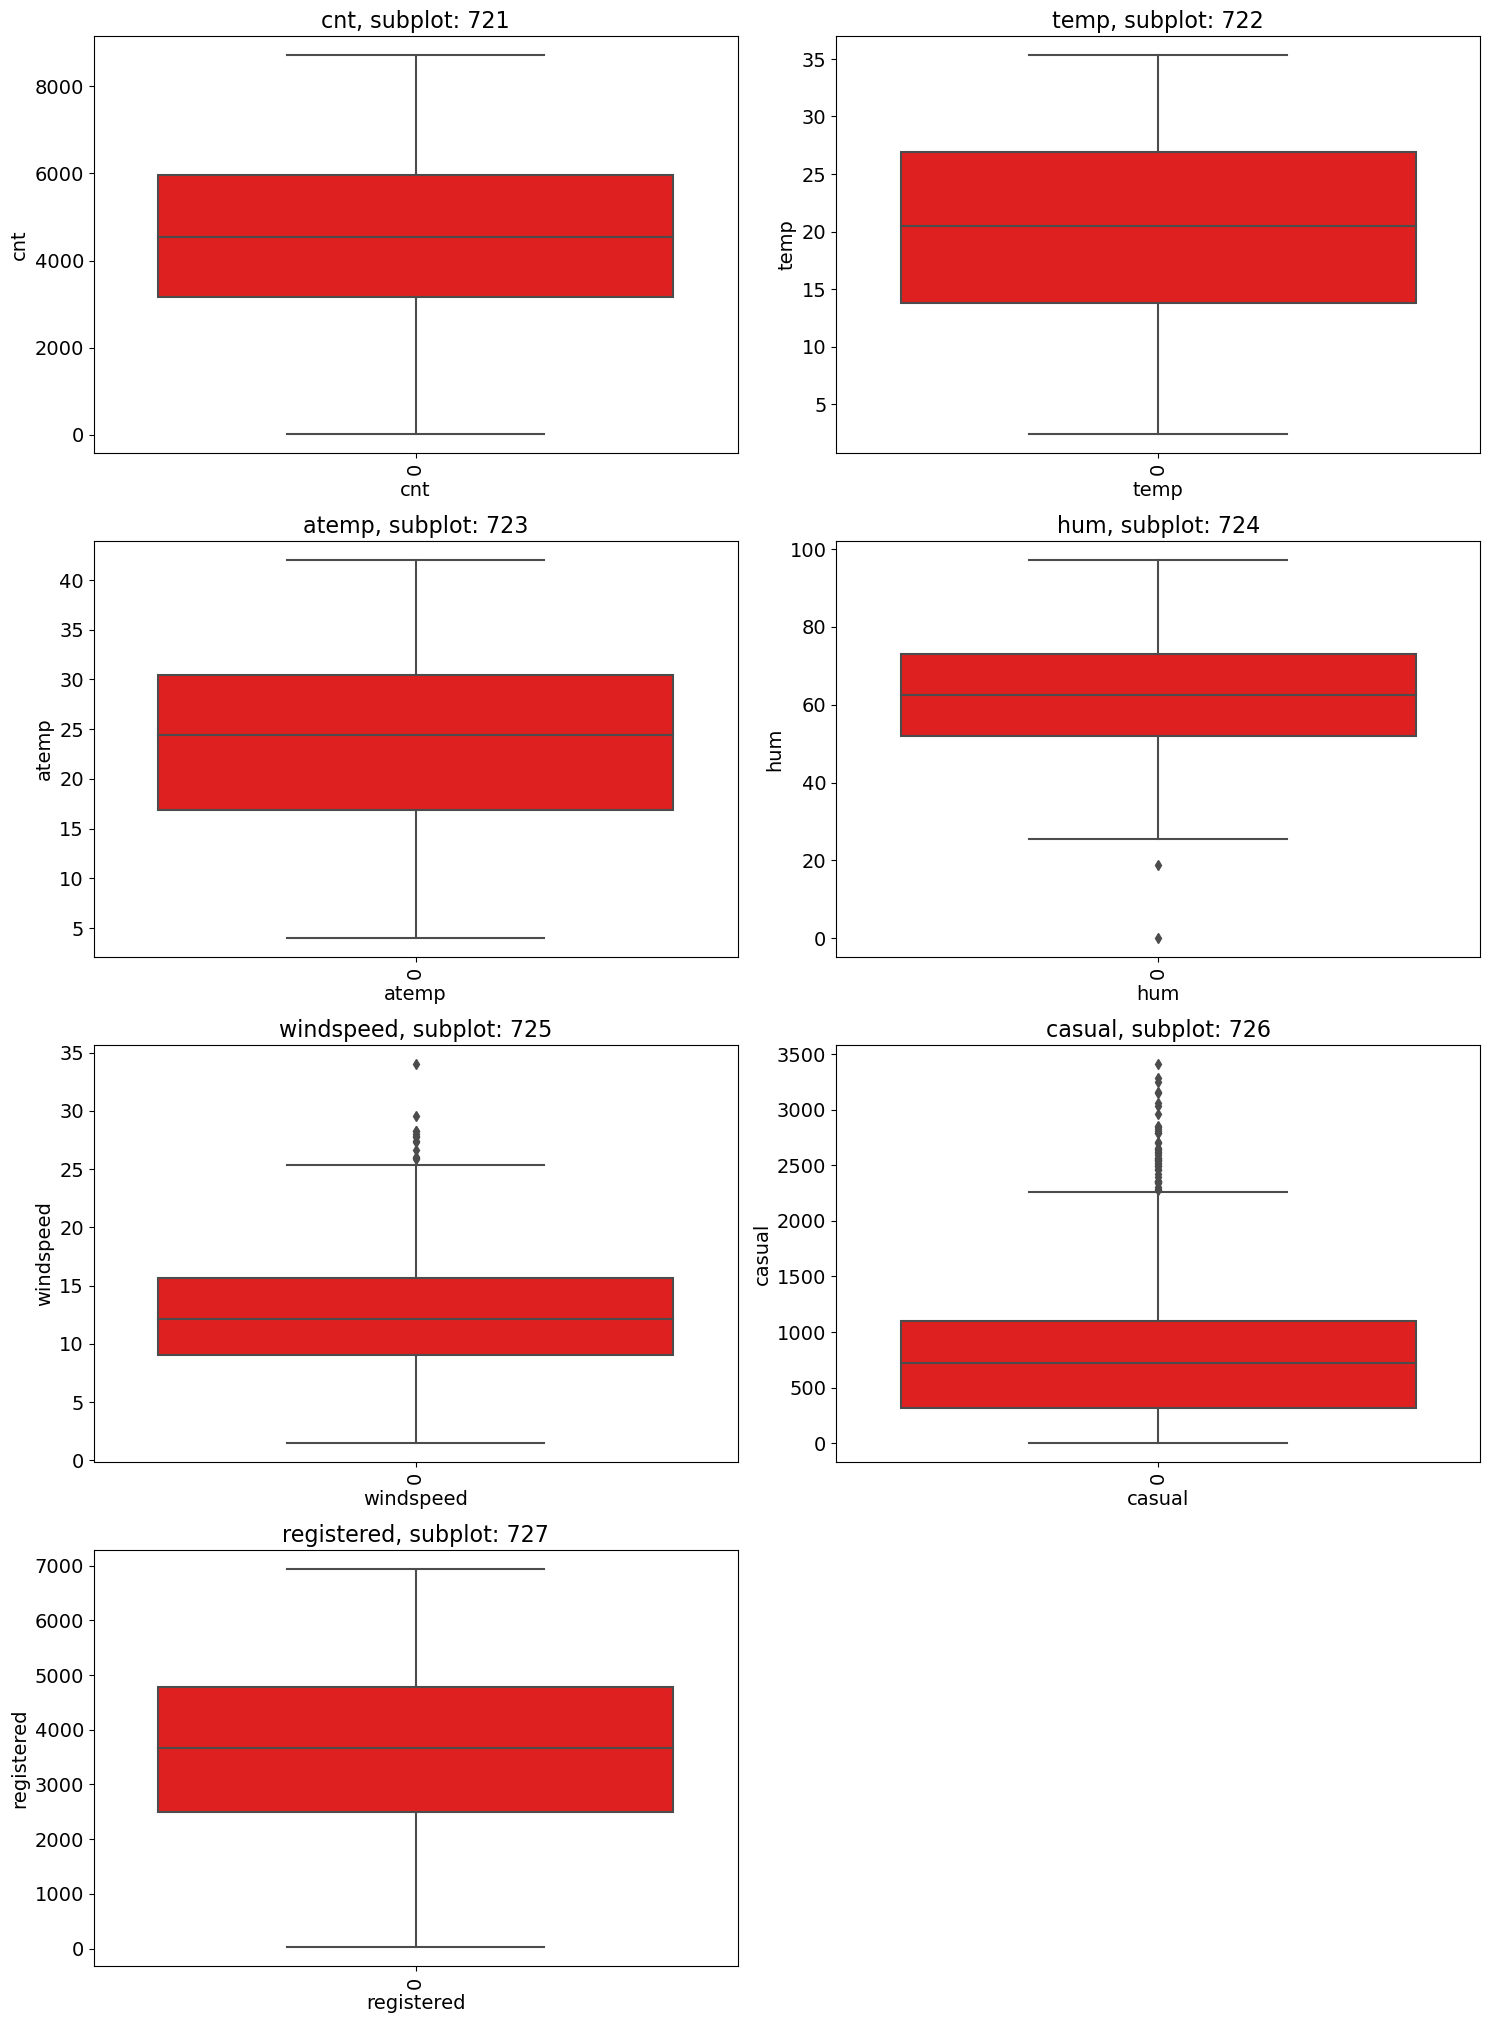

In [23]:
# Identify any outliers in numerical data
plot_to_view_outlier(len(numerical_columns), 2, numerical_columns, bike_sharing[numerical_columns])

#### <font color="brown">Understanding from Outliers:</font>
- The Numerical columns 'hum, windspeed, casual' has the outliers.

In [24]:
# Outlier Treament using IQR Technique
def treat_outlier(col_name, col):
    q1,q3 = col.quantile([0.25,0.75])
    IQR = q3-q1
    print(f"Col: '{col_name}' q1: '{q1}', q3: '{q3}' IQR:{IQR}")
    lower_range = q1-(1.5*IQR)
    upper_range = q3 + (1.5*IQR)
    return lower_range, upper_range

In [25]:
Outlier_columns = ['hum', 'windspeed', 'casual']
# Treat the outlier for numerical columns
for each_column in Outlier_columns:
    lrincome,urincome = treat_outlier(each_column, bike_sharing[each_column])
    bike_sharing[each_column] = np.where(bike_sharing[each_column]>urincome,urincome,bike_sharing[each_column])
    bike_sharing[each_column] = np.where(bike_sharing[each_column]<lrincome,lrincome,bike_sharing[each_column])

Col: 'hum' q1: '52.0', q3: '72.989575' IQR:20.989575000000002
Col: 'windspeed' q1: '9.04165', q3: '15.62558925' IQR:6.58393925
Col: 'casual' q1: '316.25', q3: '1096.5' IQR:780.25


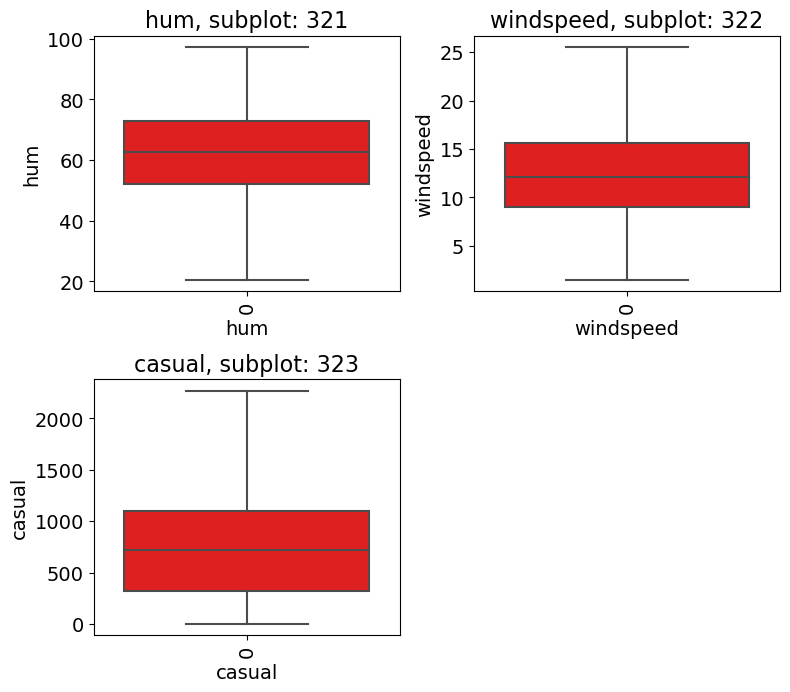

In [26]:
# Plot the outlier treated columns
plot_to_view_outlier(len(Outlier_columns), 2, Outlier_columns, bike_sharing[Outlier_columns], r_len=8, c_len=10)

## Univariate Analysis <a class="anchor" id="uv_analysis"></a>

#### Numerical Variables

In [27]:
def distplot_for_univariate(nrow, ncol, data, dataframe):
    # Number of rows in the Subplot
    a = nrow
    # Number of columns in the Subplot
    b = ncol
    # Index to be printed on Subplot
    c = 1
    fig = plt.figure(figsize=(30,40))
    fig.set_size_inches(15, 35)

    for i in data:
        plt.subplot(a,b,c)
        plt.title('{}, subplot: {}{}{}'.format(i,a,b,c),fontsize=16)
        plt.xlabel(i,fontsize=14)
        plt.ylabel(i,fontsize=14)
        plt.xticks(fontsize=10,rotation=90)
        plt.tick_params(axis='both', which='major', labelsize=14)
        sns.distplot(dataframe[i],color = 'r') #check the estimator 'mean' here by default
        c = c+1

    plt.tight_layout()
    plt.show();

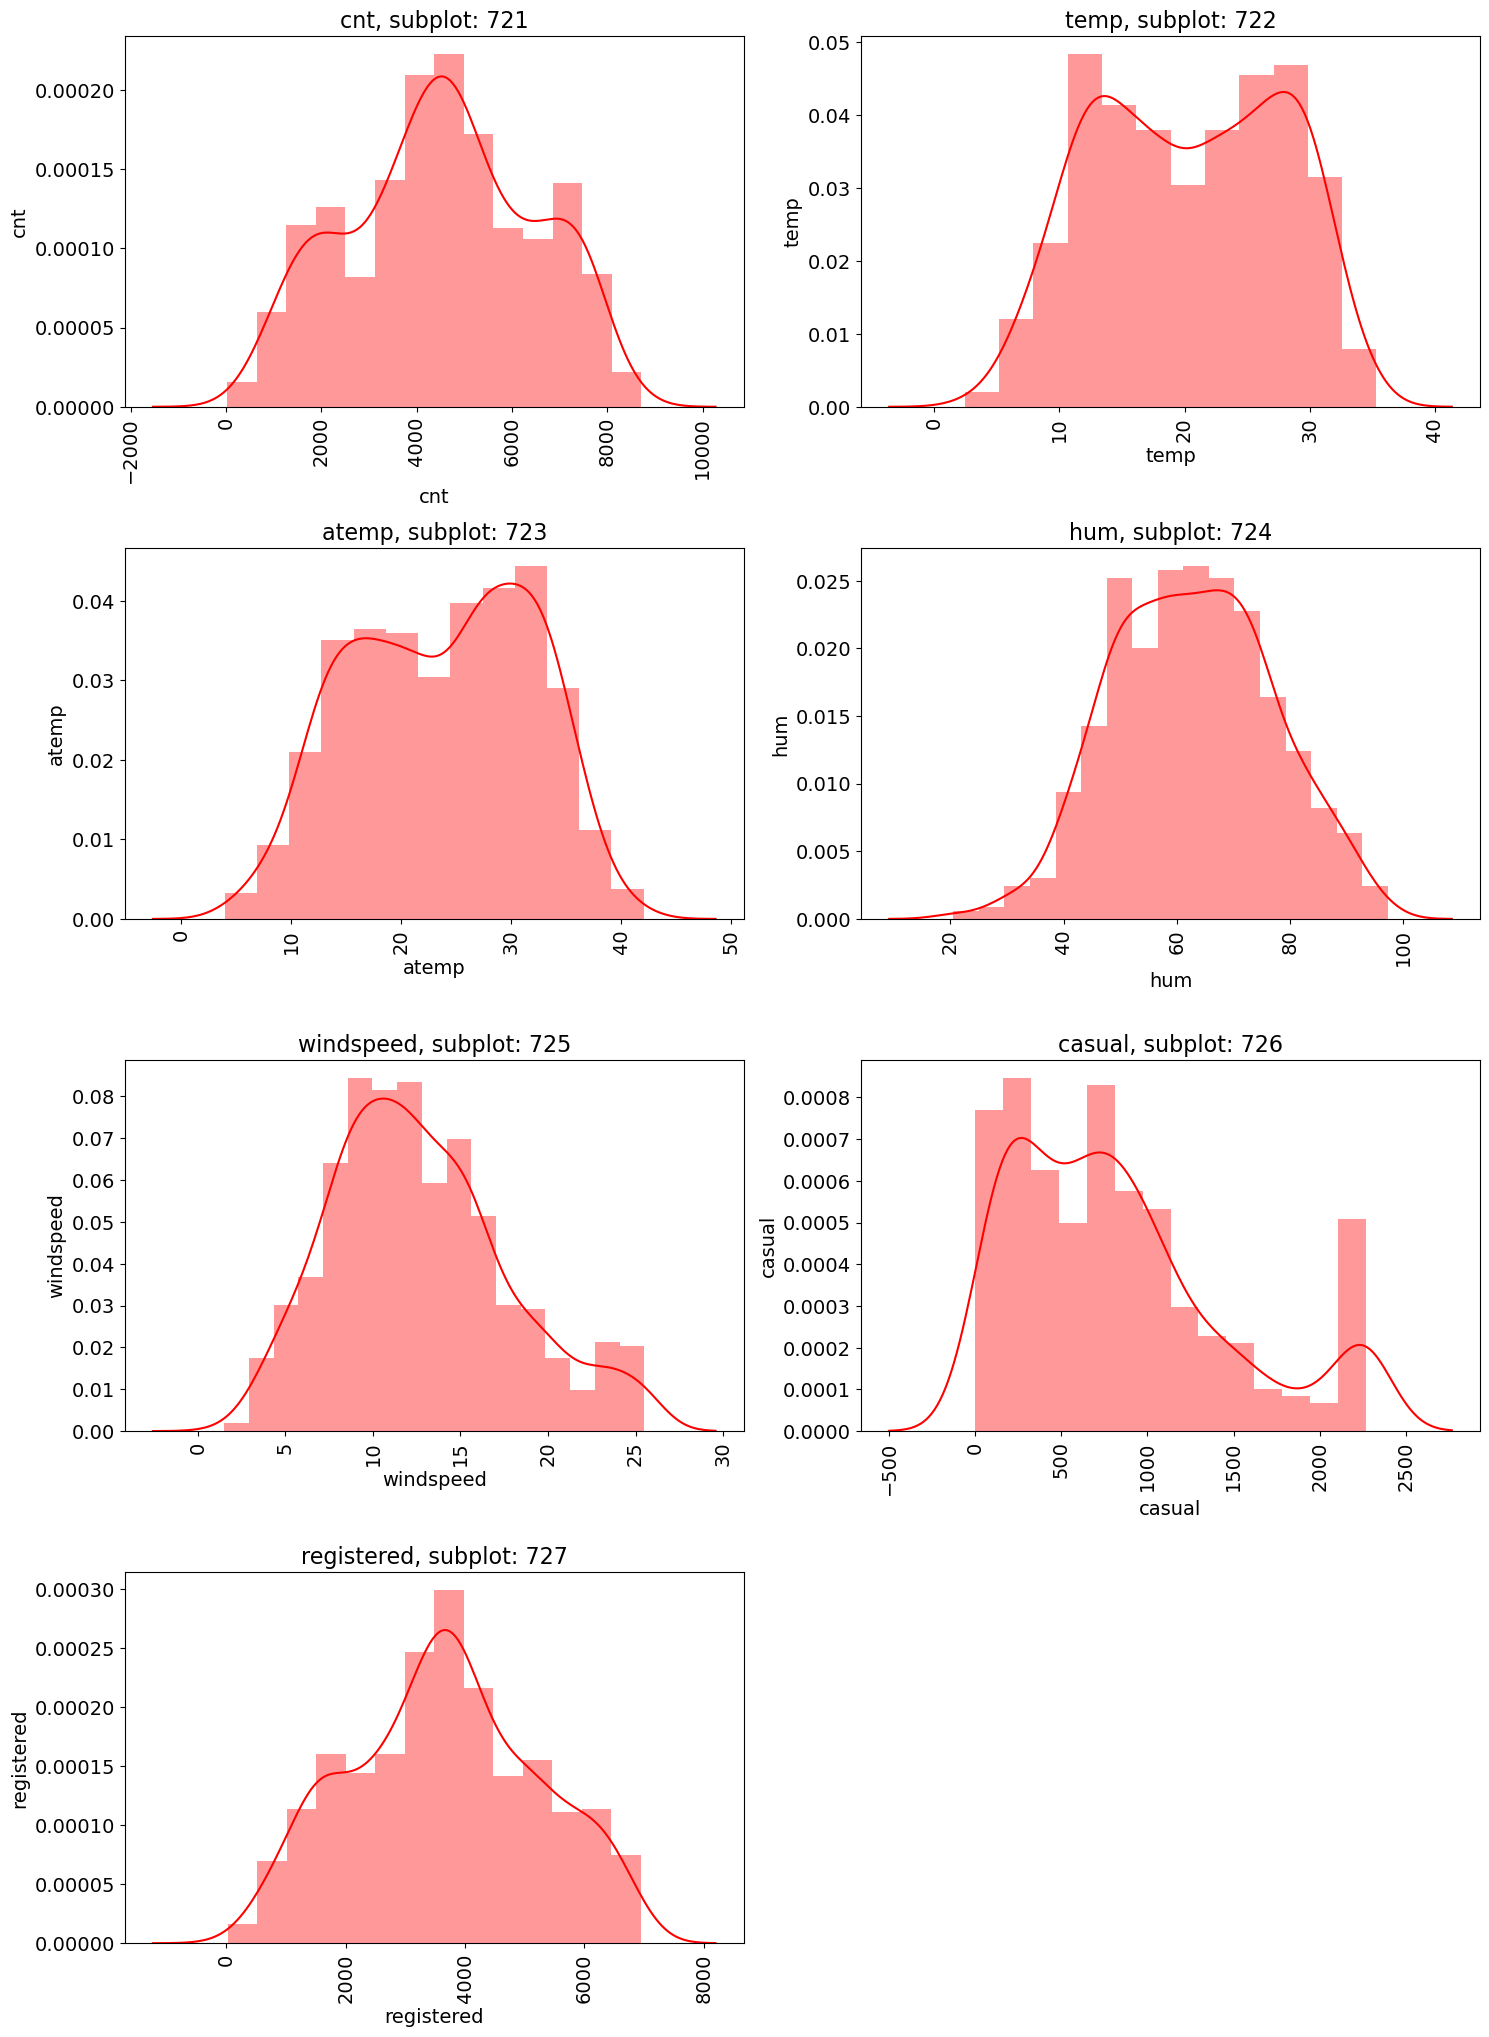

In [28]:
distplot_for_univariate(len(numerical_columns), 2, numerical_columns, bike_sharing[numerical_columns])

#### <font color="brown"> Understanding from Univariate:</font>

- The Numerical columns are not skewed, 'casual' column is lightly skewed but not high. No need a transformation

### Bivariate Analysis <a class="anchor" id="bv_analysis"></a>

#### Numerical Data

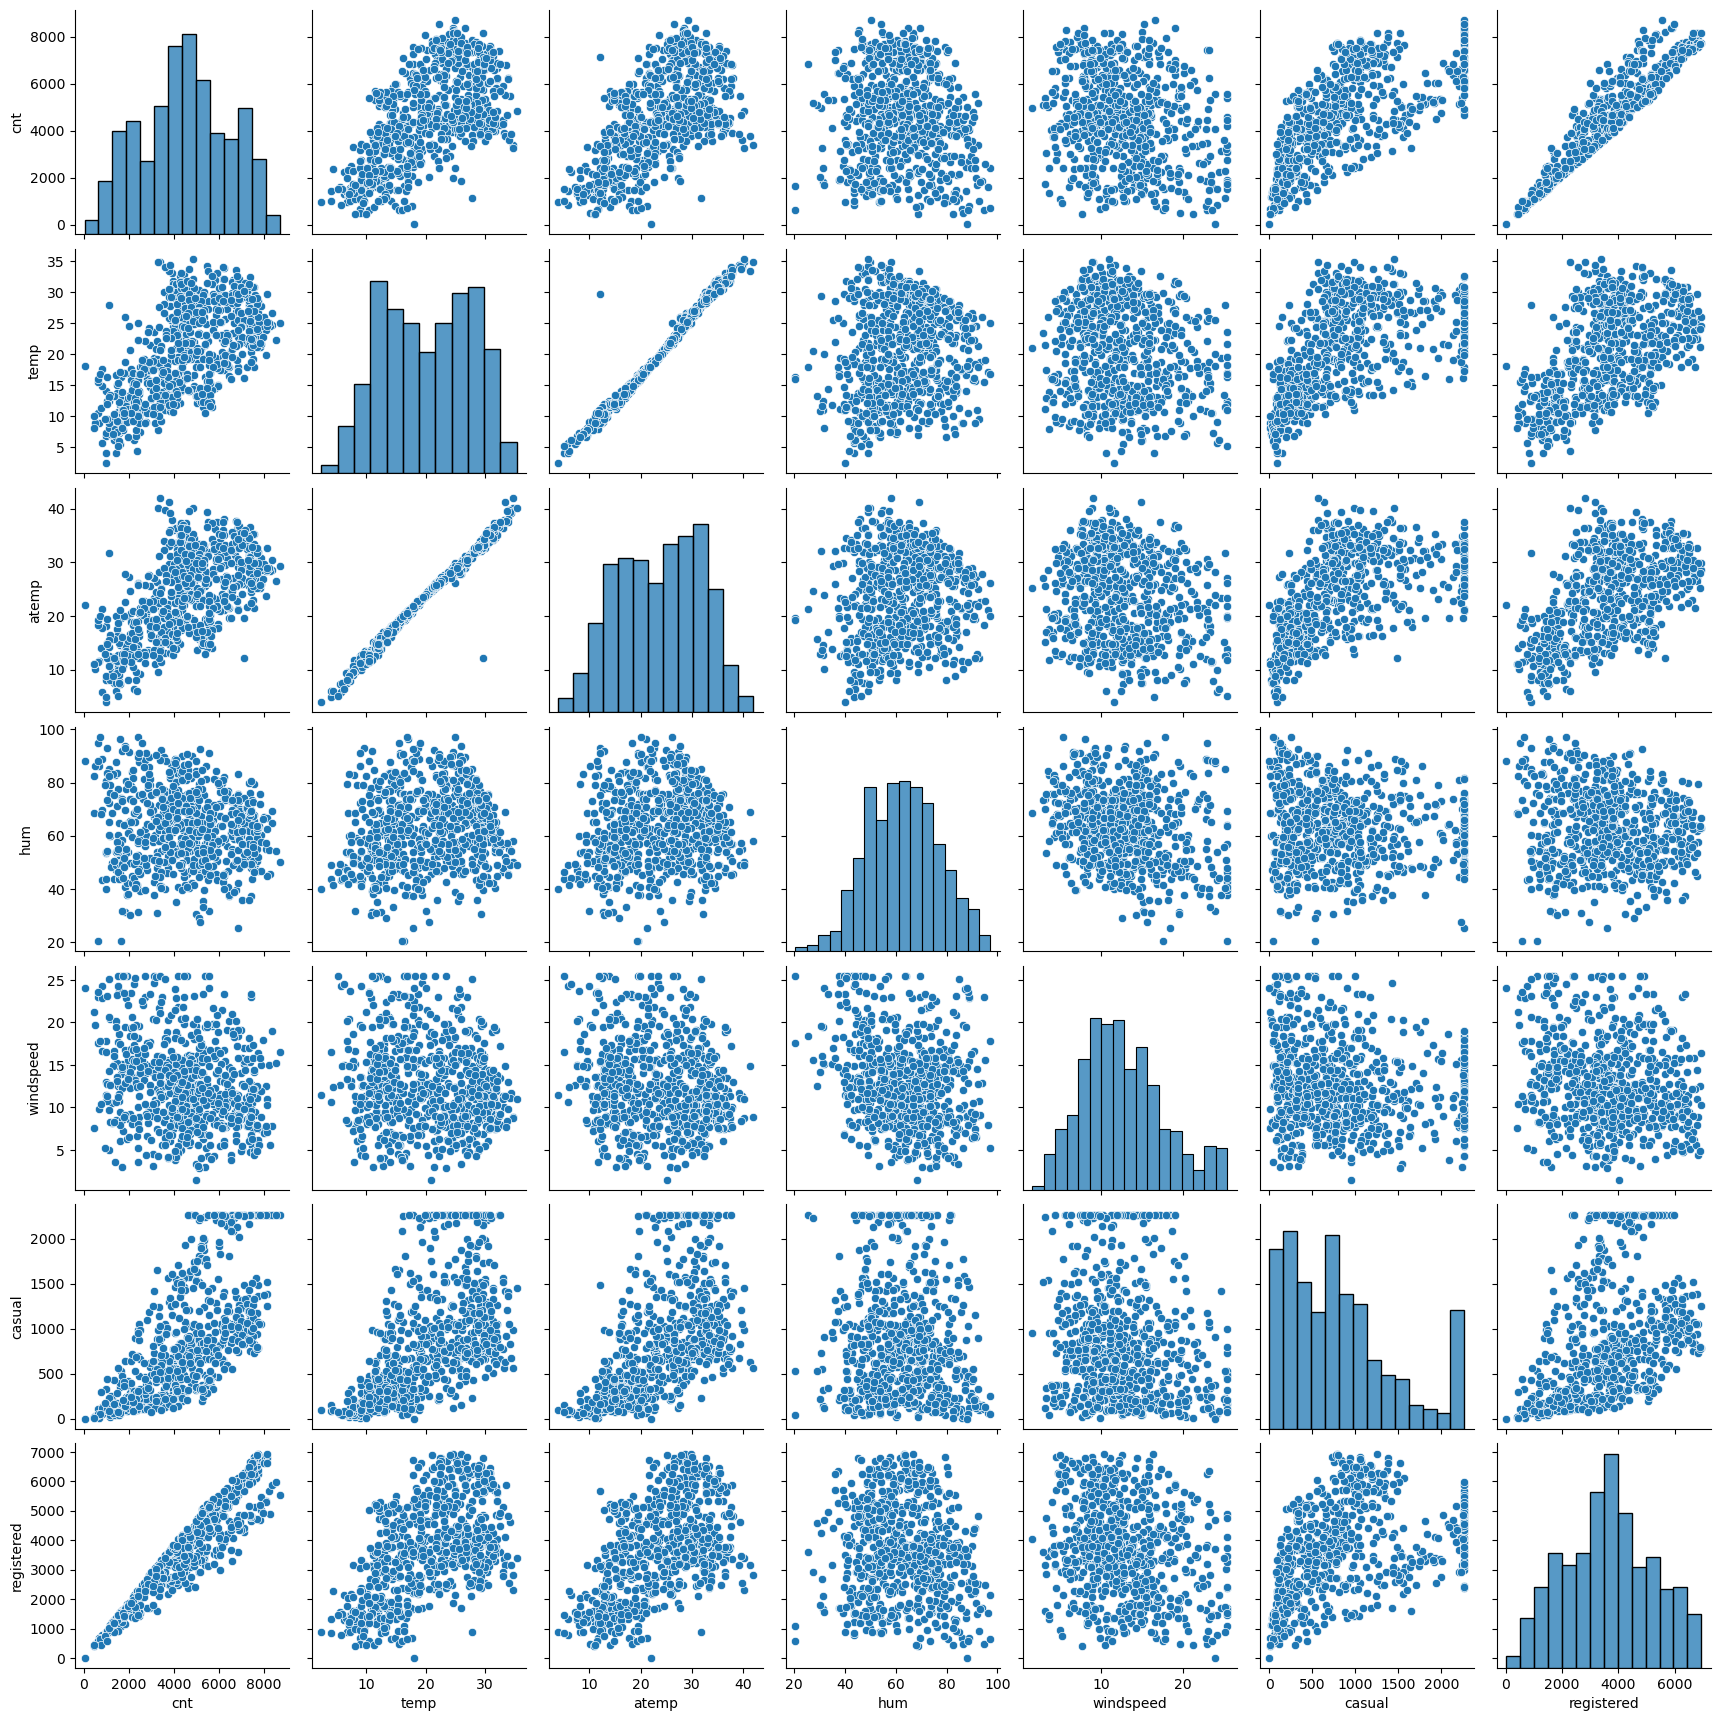

In [29]:
sns.pairplot(bike_sharing[numerical_columns])
plt.show()

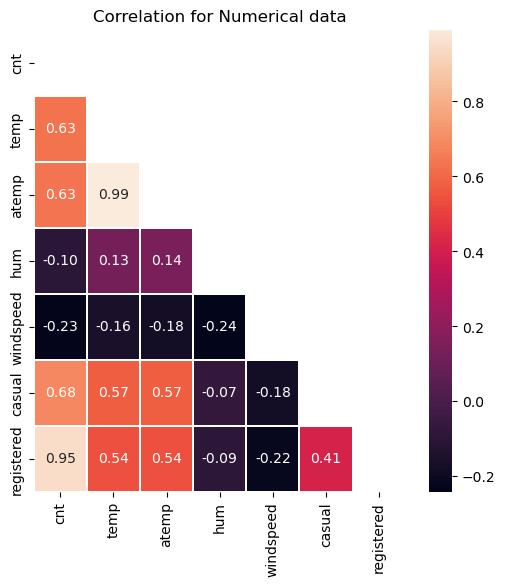

In [30]:
# co-relation Upper Triangle matrix
correlation_matrix = bike_sharing[numerical_columns].corr()
correlation_uppper_matrix = np.triu(correlation_matrix)

fig, ax = plt.subplots(figsize=(6,6))
# Masking the upper triangle matrix and rounding off with value 2.
heat_m = sns.heatmap(correlation_matrix, mask=correlation_uppper_matrix, fmt='.2f', linewidths=.2, annot=True, ax=ax)
heat_m.set_title("Correlation for Numerical data")

plt.show();

In [31]:
num_col_df = bike_sharing[numerical_columns]

In [32]:
num_col_df.corr()

,cnt,temp,atemp,hum,windspeed,casual,registered
cnt,1.000000,0.627044,0.630685,-0.103566,-0.234234,0.683828,0.945411
temp,0.627044,1.000000,0.991696,0.128332,-0.157152,0.573261,0.539436
atemp,0.630685,0.991696,1.000000,0.141456,-0.183176,0.573765,0.543678
hum,-0.103566,0.128332,0.141456,1.000000,-0.241170,-0.073192,-0.094126
windspeed,-0.234234,-0.157152,-0.183176,-0.241170,1.000000,-0.178573,-0.217384
casual,0.683828,0.573261,0.573765,-0.073192,-0.178573,1.000000,0.413727
registered,0.945411,0.539436,0.543678,-0.094126,-0.217384,0.413727,1.000000


Based on correlation, registered > casual > atemp > temp

#### Categorical Variables

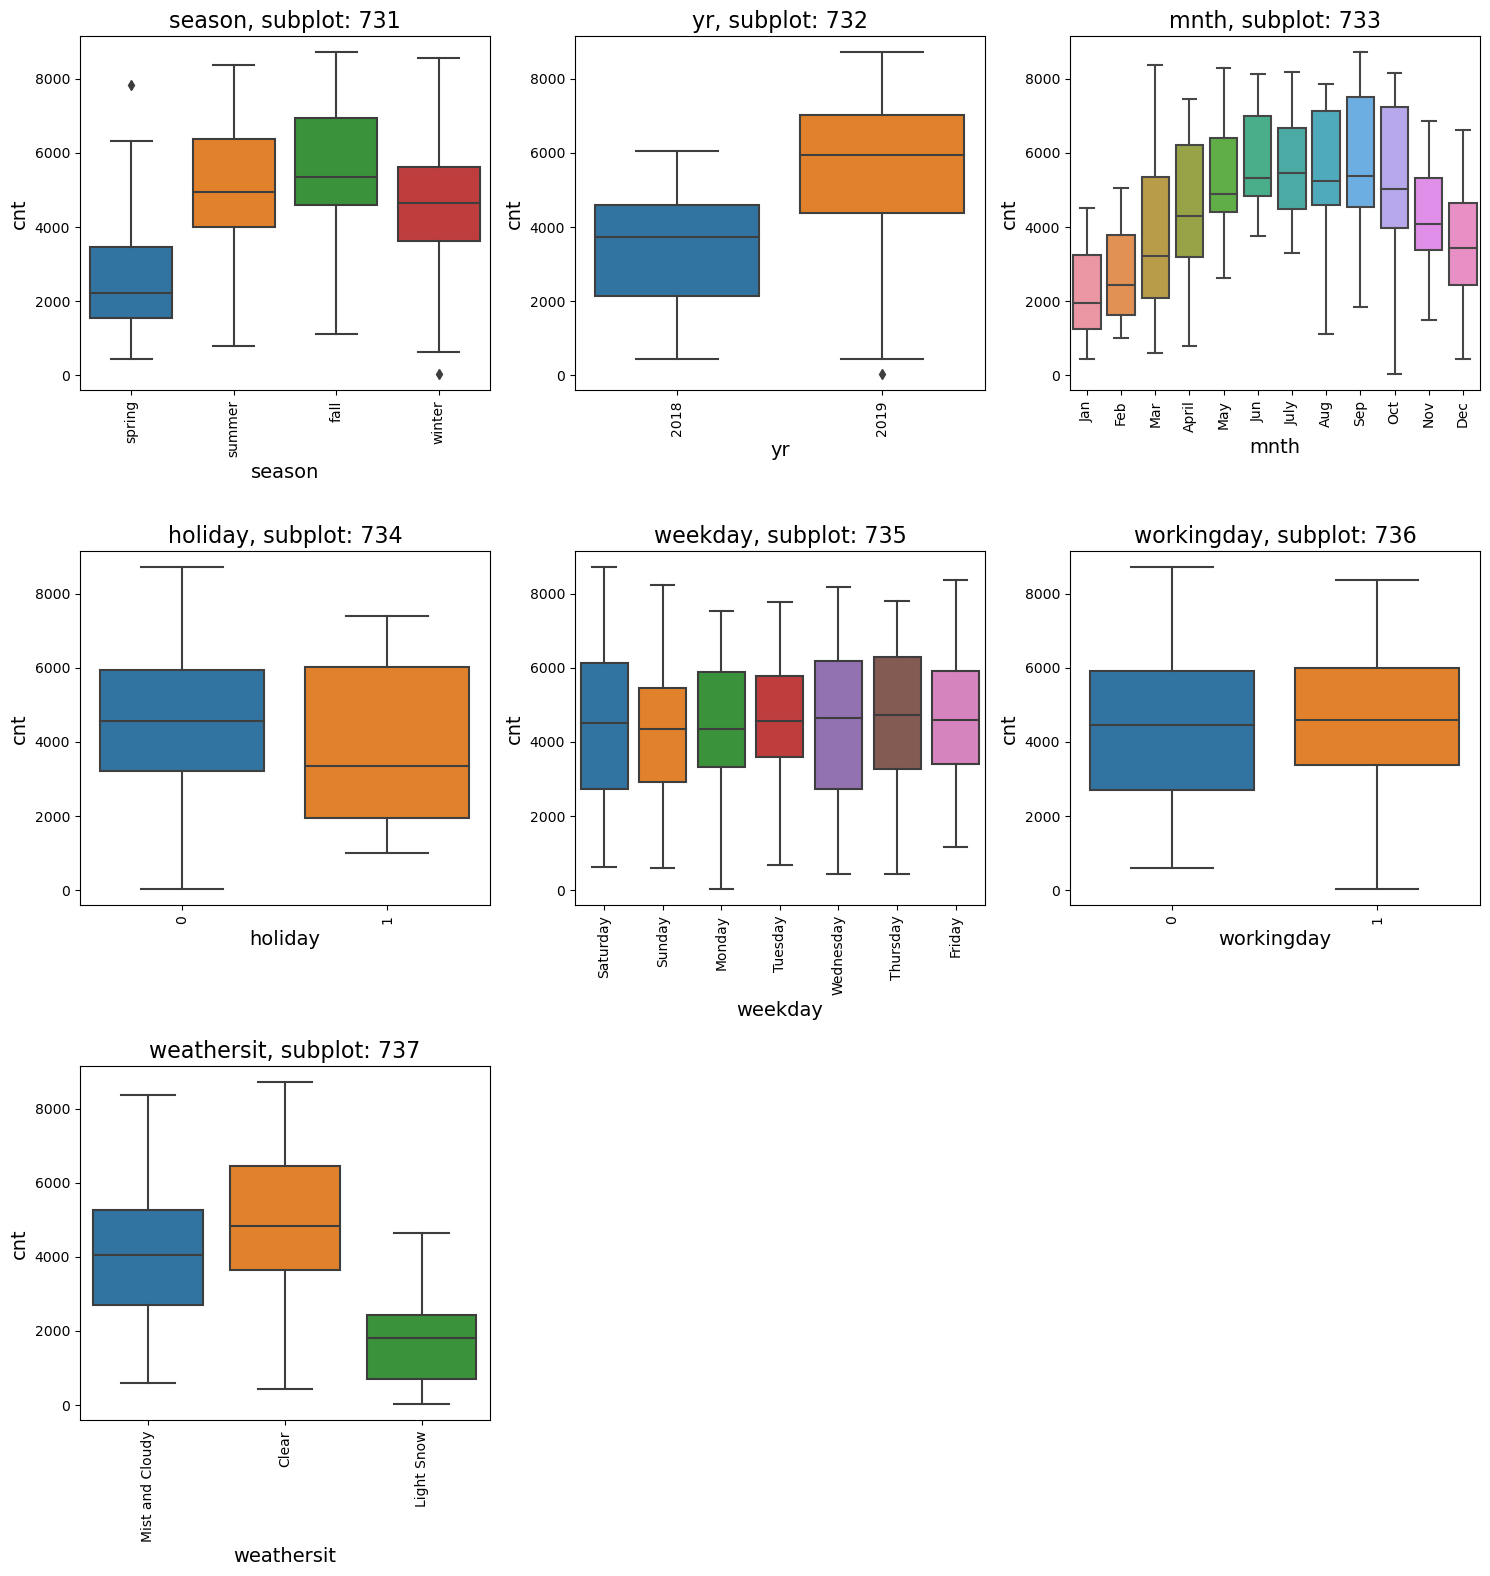

In [33]:
a = len(categorical_columns) #Rows
b = 3 # Columns
c = 1 # Index
fig = plt.figure(figsize=(30,40))
fig.set_size_inches(15, 35)

for i in categorical_columns:
    plt.subplot(a,b,c)
    plt.title('{}, subplot: {}{}{}'.format(i,a,b,c),fontsize=16)
    plt.xlabel(i,fontsize=14)
    plt.xticks(fontsize=10,rotation=90)
    plt.ylabel('cnt',fontsize=14)
    sns.boxplot(x = bike_sharing[i], y = 'cnt',  data = bike_sharing)
    c = c+1

plt.tight_layout()
plt.show();

#### <font color="brown"> Understanding from Bivariate:</font>
- The season of the summer and fall has high median where bike rental has increased.
- On year 2019, the bike rental has increased than 2018
- The month of may-oct has high median where bike rental has increased.
- The bike rental on holiday is less than the working days.
- There is no bike rental impact based on weekday.
- The weather of 'Mist & Cloudy' and 'Clear' has more bike rentals.

In [34]:
# Add a new column for the day, (months and year are available)
bike_sharing['dteday'] = pd.to_datetime(bike_sharing['dteday'])
bike_sharing['day'] = bike_sharing['dteday'].dt.day

In [35]:
bike_sharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2018-01-01,spring,2018,Jan,0,Saturday,0,Mist and Cloudy,14.110847,18.18125,80.5833,10.749882,331.0,654,985,1
1,2,2018-02-01,spring,2018,Jan,0,Sunday,0,Mist and Cloudy,14.902598,17.68695,69.6087,16.652113,131.0,670,801,1
2,3,2018-03-01,spring,2018,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,120.0,1229,1349,1
3,4,2018-04-01,spring,2018,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,108.0,1454,1562,1
4,5,2018-05-01,spring,2018,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,82.0,1518,1600,1


In [36]:
bike_sharing.shape

(730, 17)

## Step 4: Encoding <a class="anchor" id="encoding"></a>

One-Hot-Encoding is used to create dummy variables to replace the categories in a categorical variable into features of each category and represent it using 1 or 0 based on the presence or absence of the categorical value in the record.

In [37]:
print('+---------------------------+')
print('Columns \t NUnique')
print('+---------------------------+')
for each in categorical_columns:
    each_column = "{0:8}".format(each)
    print(each_column, '\t', bike_sharing[each].nunique())

+---------------------------+
Columns 	 NUnique
+---------------------------+
season   	 4
yr       	 2
mnth     	 12
holiday  	 2
weekday  	 7
workingday 	 2
weathersit 	 3


In [38]:
# Create dummy variables for columns which has more than 2 unique values 'season', 'mnth', 'weekday', 'weathersit'
dummy_var_list = ['season', 'mnth', 'weekday', 'weathersit']
dummy_var = pd.get_dummies(bike_sharing[dummy_var_list], drop_first = True)
dummy_var.head()

,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_July,mnth_Jun,mnth_Mar,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow,weathersit_Mist and Cloudy
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [39]:
bike_sharing.shape

(730, 17)

In [40]:
# Concat the dummy variable to exising dataset
bike_sharing = pd.concat([bike_sharing, dummy_var], axis = 1)
bike_sharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow,weathersit_Mist and Cloudy
0,1,2018-01-01,spring,2018,Jan,0,Saturday,0,Mist and Cloudy,14.110847,...,0,0,0,1,0,0,0,0,0,1
1,2,2018-02-01,spring,2018,Jan,0,Sunday,0,Mist and Cloudy,14.902598,...,0,0,0,0,1,0,0,0,0,1
2,3,2018-03-01,spring,2018,Jan,0,Monday,1,Clear,8.050924,...,0,0,1,0,0,0,0,0,0,0
3,4,2018-04-01,spring,2018,Jan,0,Tuesday,1,Clear,8.200000,...,0,0,0,0,0,0,1,0,0,0
4,5,2018-05-01,spring,2018,Jan,0,Wednesday,1,Clear,9.305237,...,0,0,0,0,0,0,0,1,0,0


In [41]:
# Drop those variable which are created with dummy varibles
bike_sharing = bike_sharing.drop(dummy_var_list, axis = 1)
bike_sharing.head()

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow,weathersit_Mist and Cloudy
0,1,2018-01-01,2018,0,0,14.110847,18.18125,80.5833,10.749882,331.0,...,0,0,0,1,0,0,0,0,0,1
1,2,2018-02-01,2018,0,0,14.902598,17.68695,69.6087,16.652113,131.0,...,0,0,0,0,1,0,0,0,0,1
2,3,2018-03-01,2018,0,1,8.050924,9.47025,43.7273,16.636703,120.0,...,0,0,1,0,0,0,0,0,0,0
3,4,2018-04-01,2018,0,1,8.200000,10.60610,59.0435,10.739832,108.0,...,0,0,0,0,0,0,1,0,0,0
4,5,2018-05-01,2018,0,1,9.305237,11.46350,43.6957,12.522300,82.0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
# Dropping columns casual and registered as its not required
bike_sharing.drop(['casual','registered' ], axis = 1, inplace = True)

In [43]:
#Also drop atemp fields as its having multicollinearity
bike_sharing.drop(['atemp'], axis = 1, inplace = True)

In [44]:
# Drop the column where it is already available in Day, month, year 
bike_sharing.drop(['dteday'], axis = 1, inplace = True)

In [45]:
bike_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   instant                     730 non-null    int64  
 1   yr                          730 non-null    int64  
 2   holiday                     730 non-null    int64  
 3   workingday                  730 non-null    int64  
 4   temp                        730 non-null    float64
 5   hum                         730 non-null    float64
 6   windspeed                   730 non-null    float64
 7   cnt                         730 non-null    int64  
 8   day                         730 non-null    int64  
 9   season_spring               730 non-null    uint8  
 10  season_summer               730 non-null    uint8  
 11  season_winter               730 non-null    uint8  
 12  mnth_Aug                    730 non-null    uint8  
 13  mnth_Dec                    730 non

In [46]:
bike_sharing.shape

(730, 31)

## Step 5: Train Test Split <a class="anchor" id="test_split"></a>

In [47]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(bike_sharing, train_size = 0.7, test_size = 0.3, random_state = 100)

In [48]:
df_train.shape

(510, 31)

In [49]:
df_test.shape

(219, 31)

In [50]:
num_features = list(df_train.describe().columns)
num_features

['instant',
 'yr',
 'holiday',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'cnt',
 'day',
 'season_spring',
 'season_summer',
 'season_winter',
 'mnth_Aug',
 'mnth_Dec',
 'mnth_Feb',
 'mnth_Jan',
 'mnth_July',
 'mnth_Jun',
 'mnth_Mar',
 'mnth_May',
 'mnth_Nov',
 'mnth_Oct',
 'mnth_Sep',
 'weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'weathersit_Light Snow',
 'weathersit_Mist and Cloudy']

## Step 6: Rescaling the Features <a class="anchor" id="scaling"></a>

In [51]:
std_scaler = StandardScaler()

In [52]:
# Fit transform on Train data
df_train[num_features] = std_scaler.fit_transform(df_train[num_features])
df_train

,instant,yr,holiday,workingday,temp,hum,windspeed,cnt,day,season_spring,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow,weathersit_Mist and Cloudy
653,1.359606,0.984435,-0.161731,0.691564,-0.121335,-0.523798,-0.111030,1.562685,0.039510,-0.566783,...,3.254368,-0.295669,-0.421698,-0.428129,-0.408715,-0.392232,2.571369,-0.434524,-0.174078,-0.722764
576,0.992350,0.984435,-0.161731,0.691564,1.231731,0.519287,-0.330075,1.399629,1.737544,-0.566783,...,-0.307279,-0.295669,-0.421698,-0.428129,-0.408715,-0.392232,2.571369,-0.434524,-0.174078,-0.722764
426,0.276915,0.984435,-0.161731,-1.445998,-0.420478,-0.073781,-0.386753,-0.215554,-1.432120,1.764342,...,-0.307279,-0.295669,-0.421698,2.335743,-0.408715,-0.392232,-0.388898,-0.434524,-0.174078,1.383577
728,1.717324,0.984435,-0.161731,-1.445998,-1.294913,-1.060239,2.086892,-1.379511,1.624342,1.764342,...,-0.307279,-0.295669,-0.421698,-0.428129,2.446692,-0.392232,-0.388898,-0.434524,-0.174078,-0.722764
482,0.544011,0.984435,-0.161731,-1.445998,-0.627580,-1.015536,-0.792396,-0.136589,1.397937,-0.566783,...,-0.307279,-0.295669,-0.421698,2.335743,-0.408715,-0.392232,-0.388898,-0.434524,-0.174078,1.383577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,0.753872,0.984435,-0.161731,0.691564,1.273152,-0.312197,0.221424,1.116587,-1.092513,-0.566783,...,-0.307279,-0.295669,2.371366,-0.428129,-0.408715,-0.392232,-0.388898,-0.434524,-0.174078,1.383577
578,1.001889,0.984435,-0.161731,0.691564,1.448040,0.200398,-0.800495,1.422703,-0.866108,-0.566783,...,-0.307279,-0.295669,-0.421698,-0.428129,-0.408715,2.549510,-0.388898,-0.434524,-0.174078,-0.722764
53,-1.502132,-1.015811,-0.161731,0.691564,-1.483204,-1.491466,-1.260090,-1.317467,0.831926,1.764342,...,-0.307279,-0.295669,-0.421698,-0.428129,-0.408715,-0.392232,-0.388898,2.301368,-0.174078,-0.722764
350,-0.085572,-1.015811,-0.161731,-1.445998,-1.281106,-0.505916,0.683797,-0.895981,0.152712,-0.566783,...,-0.307279,-0.295669,-0.421698,2.335743,-0.408715,-0.392232,-0.388898,-0.434524,-0.174078,1.383577


In [53]:
# Transform on Test data
df_test[num_features] = std_scaler.transform(df_test[num_features])
df_test

,instant,yr,holiday,workingday,temp,hum,windspeed,cnt,day,season_spring,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow,weathersit_Mist and Cloudy
184,-0.877319,-1.015811,6.183104,-1.445998,1.305371,0.045431,-1.424854,0.798166,-0.979311,-0.566783,...,-0.307279,-0.295669,2.371366,-0.428129,-0.408715,-0.392232,-0.388898,-0.434524,-0.174078,1.383577
535,0.796798,0.984435,-0.161731,0.691564,1.613721,-0.282399,-1.003186,0.884309,0.492319,-0.566783,...,-0.307279,-0.295669,-0.421698,-0.428129,-0.408715,-0.392232,-0.388898,2.301368,-0.174078,-0.722764
299,-0.328819,-1.015811,-0.161731,0.691564,-0.112129,1.297127,0.091661,-0.937002,1.284735,-0.566783,...,3.254368,-0.295669,-0.421698,-0.428129,-0.408715,2.549510,-0.388898,-0.434524,-0.174078,1.383577
221,-0.700845,-1.015811,-0.161731,0.691564,1.526280,-1.483427,0.124199,0.150554,-0.866108,-0.566783,...,-0.307279,-0.295669,-0.421698,-0.428129,-0.408715,-0.392232,-0.388898,2.301368,-0.174078,-0.722764
152,-1.029945,-1.015811,-0.161731,0.691564,1.240938,-2.335775,1.324395,0.246953,-1.092513,-0.566783,...,-0.307279,-0.295669,-0.421698,-0.428129,-0.408715,2.549510,-0.388898,-0.434524,-0.174078,-0.722764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,0.152907,0.984435,-0.161731,-1.445998,-1.239685,0.403058,-0.192213,-0.789328,-1.545322,1.764342,...,-0.307279,-0.295669,-0.421698,-0.428129,2.446692,-0.392232,-0.388898,-0.434524,-0.174078,1.383577
702,1.593315,0.984435,-0.161731,0.691564,-0.079915,0.730881,-0.216562,1.086847,-0.413299,-0.566783,...,-0.307279,-0.295669,-0.421698,-0.428129,-0.408715,-0.392232,2.571369,-0.434524,-0.174078,-0.722764
127,-1.149184,-1.015811,-0.161731,-1.445998,0.210028,0.000727,-1.514080,-0.078648,-1.205715,-0.566783,...,-0.307279,-0.295669,-0.421698,-0.428129,2.446692,-0.392232,-0.388898,-0.434524,-0.174078,-0.722764
640,1.297602,0.984435,-0.161731,0.691564,0.923381,1.160034,-1.619607,1.582170,-0.639704,-0.566783,...,3.254368,-0.295669,-0.421698,-0.428129,-0.408715,-0.392232,-0.388898,2.301368,-0.174078,1.383577


In [54]:
# Dividing train data into X and Y sets for the model building
y_train = df_train.pop('cnt')
X_train = df_train

In [55]:
X_train.head()

,instant,yr,holiday,workingday,temp,hum,windspeed,day,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow,weathersit_Mist and Cloudy
653,1.359606,0.984435,-0.161731,0.691564,-0.121335,-0.523798,-0.111030,0.039510,-0.566783,-0.569803,...,3.254368,-0.295669,-0.421698,-0.428129,-0.408715,-0.392232,2.571369,-0.434524,-0.174078,-0.722764
576,0.992350,0.984435,-0.161731,0.691564,1.231731,0.519287,-0.330075,1.737544,-0.566783,-0.569803,...,-0.307279,-0.295669,-0.421698,-0.428129,-0.408715,-0.392232,2.571369,-0.434524,-0.174078,-0.722764
426,0.276915,0.984435,-0.161731,-1.445998,-0.420478,-0.073781,-0.386753,-1.432120,1.764342,-0.569803,...,-0.307279,-0.295669,-0.421698,2.335743,-0.408715,-0.392232,-0.388898,-0.434524,-0.174078,1.383577
728,1.717324,0.984435,-0.161731,-1.445998,-1.294913,-1.060239,2.086892,1.624342,1.764342,-0.569803,...,-0.307279,-0.295669,-0.421698,-0.428129,2.446692,-0.392232,-0.388898,-0.434524,-0.174078,-0.722764
482,0.544011,0.984435,-0.161731,-1.445998,-0.627580,-1.015536,-0.792396,1.397937,-0.566783,1.754993,...,-0.307279,-0.295669,-0.421698,2.335743,-0.408715,-0.392232,-0.388898,-0.434524,-0.174078,1.383577


In [56]:
X_train.corr()

,instant,yr,holiday,workingday,temp,hum,windspeed,day,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow,weathersit_Mist and Cloudy
instant,1.000000,0.862560,0.003428,0.012180,0.213516,0.037049,-0.095320,0.136919,-0.329252,-0.151641,...,0.140883,0.106227,0.049252,-0.022445,0.005375,6.190071e-03,-0.009138,-0.010266,-1.389977e-02,-0.024815
yr,0.862560,1.000000,-0.014980,0.031808,0.107288,-0.088941,-0.001871,0.000620,-0.036320,0.013856,...,-0.018790,0.002574,0.053634,-0.033817,-0.000812,-6.153420e-03,-0.000296,-0.001452,-6.076399e-02,-0.015469
holiday,0.003428,-0.014980,1.000000,-0.233863,-0.066282,-0.029934,0.019719,0.012023,0.053339,-0.063232,...,-0.005387,0.043692,0.279279,-0.069242,-0.066102,9.759407e-03,-0.062897,-0.070276,-2.815377e-02,-0.038279
workingday,0.012180,0.031808,-0.233863,1.000000,0.067787,0.034000,-0.038293,0.010634,-0.037932,0.043274,...,-0.041271,0.019495,0.174565,-0.619074,-0.591001,2.465943e-01,0.268948,0.300501,2.115873e-02,0.040766
temp,0.213516,0.107288,-0.066282,0.067787,1.000000,0.155483,-0.186961,0.079998,-0.605988,0.125582,...,-0.018709,0.207457,-0.032126,-0.042274,-0.017048,2.826576e-03,0.046646,0.029363,-3.609266e-02,-0.090161
hum,0.037049,-0.088941,-0.029934,0.034000,0.155483,1.000000,-0.258698,0.076428,-0.197958,-0.015146,...,0.162929,0.153471,0.021559,-0.041657,0.011090,-3.142313e-02,0.009027,0.046376,2.643588e-01,0.484352
windspeed,-0.095320,-0.001871,0.019719,-0.038293,-0.186961,-0.258698,1.000000,-0.046556,0.172727,0.117958,...,-0.021785,-0.122270,-0.001019,0.041378,-0.000469,-8.219992e-03,-0.002639,-0.018164,9.118887e-02,-0.025276
day,0.136919,0.000620,0.012023,0.010634,0.079998,0.076428,-0.046556,1.000000,-0.181991,-0.028058,...,0.106217,0.004335,0.030920,-0.000876,-0.018711,3.090699e-03,-0.017489,-0.019268,1.081897e-02,-0.049990
season_spring,-0.329252,-0.036320,0.053339,-0.037932,-0.605988,-0.197958,0.172727,-0.181991,1.000000,-0.322955,...,-0.174161,-0.167580,-0.009212,0.022641,0.003276,6.274901e-03,-0.030988,-0.008680,-4.455809e-02,0.013970
season_summer,-0.151641,0.013856,-0.063232,0.043274,0.125582,-0.015146,0.117958,-0.028058,-0.322955,1.000000,...,-0.175089,-0.168473,0.001623,-0.017169,-0.011612,-2.234951e-02,0.021300,0.039248,-4.523062e-02,0.039442


## Step 7: Feature Selection <a class="anchor" id="selection"></a>

### RFE  <a class="anchor" id="rfe"></a>

In [57]:
# Recursive feature elimination
lm = LinearRegression()

# running RFE
rfe = RFE(estimator = lm, n_features_to_select = 15, verbose=True)
rfe = rfe.fit(X_train, y_train)

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.


In [58]:
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True  True  True False  True  True  True False
 False False False  True False False False False False  True False  True
  True False False False  True  True]
[ 9  1  1  1  1  1  1 12  1  1  1 16  4  5  2  1 10 15  6  3 11  1  7  1
  1 13  8 14  1  1]


In [59]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                     'Support':rfe.support_,
                                     'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Support,Ranking
29,weathersit_Mist and Cloudy,True,1
1,yr,True,1
2,holiday,True,1
3,workingday,True,1
4,temp,True,1
5,hum,True,1
6,windspeed,True,1
24,weekday_Sunday,True,1
8,season_spring,True,1
9,season_summer,True,1


In [60]:
X_train_col = X_train.columns[rfe.support_]
X_train_col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'mnth_July',
       'mnth_Sep', 'weekday_Saturday', 'weekday_Sunday',
       'weathersit_Light Snow', 'weathersit_Mist and Cloudy'],
      dtype='object')

In [61]:
X_train.columns[~rfe.support_]

Index(['instant', 'day', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan',
       'mnth_Jun', 'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct',
       'weekday_Monday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday'],
      dtype='object')

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 653 to 79
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   instant                     510 non-null    float64
 1   yr                          510 non-null    float64
 2   holiday                     510 non-null    float64
 3   workingday                  510 non-null    float64
 4   temp                        510 non-null    float64
 5   hum                         510 non-null    float64
 6   windspeed                   510 non-null    float64
 7   day                         510 non-null    float64
 8   season_spring               510 non-null    float64
 9   season_summer               510 non-null    float64
 10  season_winter               510 non-null    float64
 11  mnth_Aug                    510 non-null    float64
 12  mnth_Dec                    510 non-null    float64
 13  mnth_Feb                    510 no

## Step 8: Building model using statsmodel, for the detailed statistics <a class="anchor" id="buildmodel"></a>

In [63]:
X_train_model1 = X_train[X_train_col]

# Adding constant variable on model1
X_train_model1 = sm.add_constant(X_train_model1)

# Running statsmodel
lm_model1 = sm.OLS(y_train,X_train_model1).fit()

# Print Summary
print(lm_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          2.13e-191
Time:                        19:31:55   Log-Likelihood:                -244.96
No. Observations:                 510   AIC:                             519.9
Df Residuals:                     495   BIC:                             583.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<font color="blue"> R-squared value is 0.847 but the P value less than 0.05 </font>

In [64]:
# Verify the VIF
def calc_vif(train):
    vif = pd.DataFrame()
    vif['Features'] = train.columns
    vif['VIF'] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [65]:
calc_vif(X_train_model1)

                      Features   VIF
2                      holiday   inf
3                   workingday   inf
12            weekday_Saturday   inf
13              weekday_Sunday   inf
7                season_spring  5.02
4                         temp  3.64
9                season_winter  3.50
8                season_summer  2.62
5                          hum  1.97
15  weathersit_Mist and Cloudy  1.60
10                   mnth_July  1.49
11                    mnth_Sep  1.30
14       weathersit_Light Snow  1.29
6                    windspeed  1.20
1                           yr  1.04
0                        const  1.00


In [66]:
#Droping season_spring column and checking model
X_train_model1 = X_train_model1.drop(["holiday"], axis = 1)

In [67]:
# Adding constant variable on model1
X_train_model2 = sm.add_constant(X_train_model1)

# Running statsmodel
lm_model2 = sm.OLS(y_train,X_train_model2).fit()

# Print Summary
print(lm_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          2.13e-191
Time:                        19:32:10   Log-Likelihood:                -244.96
No. Observations:                 510   AIC:                             519.9
Df Residuals:                     495   BIC:                             583.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [68]:
calc_vif(X_train_model2)

                      Features   VIF
2                   workingday  9.07
11            weekday_Saturday  6.06
12              weekday_Sunday  5.74
6                season_spring  5.02
3                         temp  3.64
8                season_winter  3.50
7                season_summer  2.62
4                          hum  1.97
14  weathersit_Mist and Cloudy  1.60
9                    mnth_July  1.49
10                    mnth_Sep  1.30
13       weathersit_Light Snow  1.29
5                    windspeed  1.20
1                           yr  1.04
0                        const  1.00


In [69]:
#Droping season_spring column and checking model
X_train_model2 = X_train_model2.drop(["workingday"], axis = 1)

In [70]:
# Adding constant variable on model1
X_train_model3 = sm.add_constant(X_train_model2)

# Running statsmodel
lm_model3 = sm.OLS(y_train,X_train_model3).fit()

# Print Summary
print(lm_model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     203.3
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          4.09e-189
Time:                        19:32:16   Log-Likelihood:                -253.17
No. Observations:                 510   AIC:                             534.3
Df Residuals:                     496   BIC:                             593.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [71]:
calc_vif(X_train_model3)

                      Features   VIF
5                season_spring  5.02
2                         temp  3.64
7                season_winter  3.50
6                season_summer  2.62
3                          hum  1.97
13  weathersit_Mist and Cloudy  1.60
8                    mnth_July  1.49
9                     mnth_Sep  1.29
12       weathersit_Light Snow  1.28
4                    windspeed  1.20
11              weekday_Sunday  1.05
1                           yr  1.04
10            weekday_Saturday  1.04
0                        const  1.00


In [72]:
#Droping season_spring column and checking model
X_train_model3 = X_train_model3.drop(["season_spring"], axis = 1)

In [73]:
# Adding constant variable on model1
X_train_model4 = sm.add_constant(X_train_model3)

# Running statsmodel
lm_model4 = sm.OLS(y_train,X_train_model4).fit()

# Print Summary
print(lm_model4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     216.6
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.32e-188
Time:                        19:32:24   Log-Likelihood:                -257.18
No. Observations:                 510   AIC:                             540.4
Df Residuals:                     497   BIC:                             595.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [74]:
calc_vif(X_train_model4)

                      Features   VIF
3                          hum  1.94
2                         temp  1.61
12  weathersit_Mist and Cloudy  1.59
7                    mnth_July  1.43
5                season_summer  1.33
6                season_winter  1.29
11       weathersit_Light Snow  1.27
8                     mnth_Sep  1.19
4                    windspeed  1.18
10              weekday_Sunday  1.05
9             weekday_Saturday  1.04
1                           yr  1.03
0                        const  1.00


<font color="blue"> R-squared value is 0.839 and P value is 0, VIF is less than 5 </font>

## Step 9: Residual Analysis of the train data <a class="anchor" id="res_analysis"></a>

In [75]:
y_train_cnt = lm_model4.predict(X_train_model4)

Text(0.5, 0, 'Errors')

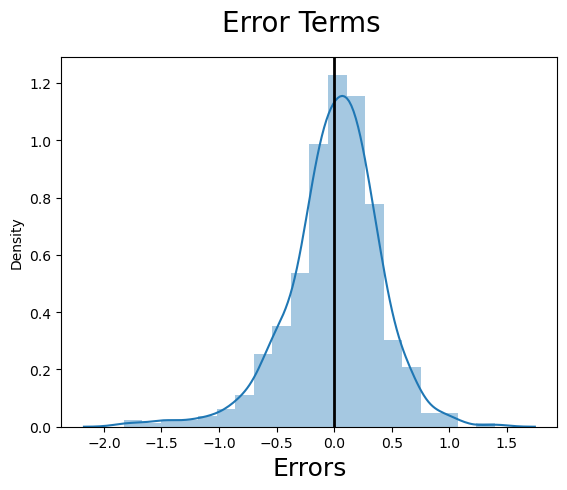

In [76]:
# Plot the histogram of the error terms
fig = plt.figure()
residuals = y_train - y_train_cnt
sns.distplot(residuals, bins = 20)
plt.axvline(residuals.mean(), color='k', lw=2)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

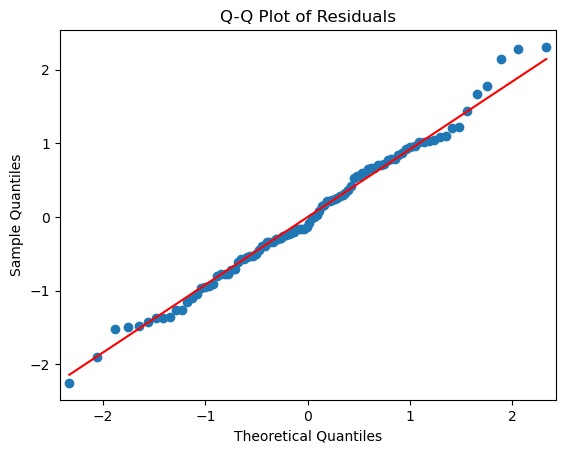

In [2942]:
# Examine the residuals using the normal distribution
qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

#### <font color="brown"> Understanding from Residual Analysis:</font>
- The Error term plot is normally distributed with a mean value = 0.
- Q-Q plot confirms that the residuals are normally distributed.

## Step 10: Making Predictions Using the Final Model  <a class="anchor" id="final_model"></a>

In [77]:
y_test_new = df_test.pop('cnt')
X_test_new = df_test

In [78]:
X_test_new.columns

Index(['instant', 'yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'day', 'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_July', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_Light Snow',
       'weathersit_Mist and Cloudy'],
      dtype='object')

In [79]:
X_train_model4.columns

Index(['const', 'yr', 'temp', 'hum', 'windspeed', 'season_summer',
       'season_winter', 'mnth_July', 'mnth_Sep', 'weekday_Saturday',
       'weekday_Sunday', 'weathersit_Light Snow',
       'weathersit_Mist and Cloudy'],
      dtype='object')

In [80]:
train_model_col = [ 'yr', 'temp', 'hum', 'windspeed', 'season_summer',
       'season_winter', 'mnth_July', 'mnth_Sep', 'weekday_Saturday',
       'weekday_Sunday', 'weathersit_Light Snow',
       'weathersit_Mist and Cloudy' ]

In [81]:
X_test_result = X_test_new[train_model_col]

# Adding a constant variable 
X_test_result = sm.add_constant(X_test_result)

In [82]:
y_pred_m4 = lm_model4.predict(X_test_result)
y_pred_m4.head()

184   -0.093728
535    1.886143
299   -0.504622
221    0.422021
152    0.544672
dtype: float64

## Step 11: Model Evaluation  <a class="anchor" id="model_evaluation"></a>

Let's now plot the graph for actual versus predicted values.

Text(0, 0.5, 'y_pred')

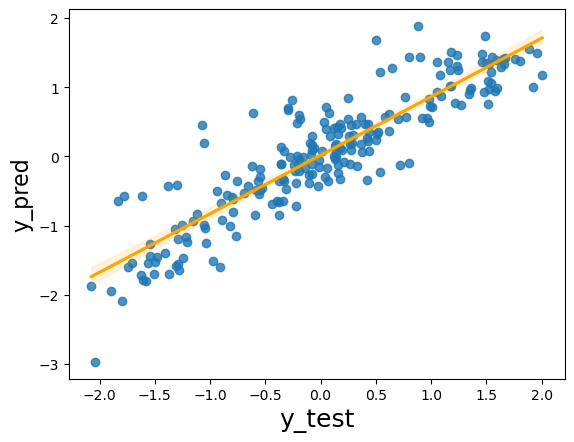

In [83]:
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
sns.regplot(x=y_test_new, y=y_pred_m4, data=X_train_model4, line_kws={"color": "orange"});
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)     

### Evaluating Model with R2 score for the actual vs prediction

In [84]:
r2_score(y_test_new, y_pred_m4)

0.8044764478638162

### Coefficient of model

In [85]:
ress = pd.DataFrame(lm_model4.params)
ress.columns=['Coef']
coef_val = ress.round(3)
coef_val.sort_values(by=['Coef'], ascending=False)

,Coef
temp,0.603
yr,0.509
season_winter,0.262
season_summer,0.159
mnth_Sep,0.111
weekday_Saturday,0.021
const,-0.000
mnth_July,-0.052
weekday_Sunday,-0.062
weathersit_Mist and Cloudy,-0.110


In [86]:
coef_index = coef_val.index.tolist()
coef_value = coef_val.Coef.tolist()
fmt_str = ""
for idx,val in zip(coef_index, coef_value):
    if 'const' in idx:
        continue
    end_str = ''
    if coef_index[-1] != idx:
        end_str = ' + '
    fmt_str = fmt_str + f"({val} * {idx})" + end_str
cnt = 'cnt = ' + fmt_str

We can see that the equation of our best fitted line is:

In [87]:
cnt

'cnt = (0.509 * yr) + (0.603 * temp) + (-0.114 * hum) + (-0.142 * windspeed) + (0.159 * season_summer) + (0.262 * season_winter) + (-0.052 * mnth_July) + (0.111 * mnth_Sep) + (0.021 * weekday_Saturday) + (-0.062 * weekday_Sunday) + (-0.174 * weathersit_Light Snow) + (-0.11 * weathersit_Mist and Cloudy)'

## Conclusion  <a class="anchor" id="conclusions"></a>

* Based on the R2 Square value (0.804) on the test model evaluation predicts that this model is good.
* Coefficients:
   - Positive Coefficients: yr, temp, season_summer, season_winter, mnth_Sep, weekday_Saturday
   - Negative Coefficients: hum, windspeed, mnth_July, weekday_Sunday, weathersit_Light Snow, weathersit_Mist and Cloud
* On year 2019, the bike rental has increased.   